In [5]:
from transformers import AutoModelForImageTextToText,AutoProcessor

model_name = 'google/gemma-3-4b-it'
# model = AutoModelForImageTextToText.from_pretrained(model_name)
processor = AutoProcessor.from_pretrained(model_name)

In [42]:
model.config

Gemma3Config {
  "architectures": [
    "Gemma3ForConditionalGeneration"
  ],
  "boi_token_index": 255999,
  "dtype": "float32",
  "eoi_token_index": 256000,
  "eos_token_id": [
    1,
    106
  ],
  "image_token_index": 262144,
  "initializer_range": 0.02,
  "mm_tokens_per_image": 256,
  "model_type": "gemma3",
  "text_config": {
    "_sliding_window_pattern": 6,
    "attention_bias": false,
    "attention_dropout": 0.0,
    "attn_logit_softcapping": null,
    "dtype": "float32",
    "final_logit_softcapping": null,
    "head_dim": 256,
    "hidden_activation": "gelu_pytorch_tanh",
    "hidden_size": 2560,
    "initializer_range": 0.02,
    "intermediate_size": 10240,
    "layer_types": [
      "sliding_attention",
      "sliding_attention",
      "sliding_attention",
      "sliding_attention",
      "sliding_attention",
      "full_attention",
      "sliding_attention",
      "sliding_attention",
      "sliding_attention",
      "sliding_attention",
      "sliding_attention",
      "

In [81]:
# %%
# =================================================================================
# Cell 1: Setup and Environment Creation
# =================================================================================
# This cell installs necessary packages, creates a standard image-based
# environment, and defines a prompt_formatter for it.

# --- 1. Install Dependencies ---
# Note: You might need to restart the kernel after this installation.

import gymnasium as gym
from PIL import Image
import numpy as np
from typing import Any, Tuple, List, Dict

print("--- Dependencies Installed ---")

# --- 2. Create the Standard Environment ---
# CarRacing-v2 is a great choice because its observation is a standard
# (96, 96, 3) RGB image array, perfect for our LVLM.
env = gym.make("CarRacing-v2")
print("\n--- CarRacing-v2 Environment Created ---")
print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space}")
# The action space is continuous, but we will discretize it in the formatter.

# --- 3. Define the Corresponding Prompt Formatter ---
# This function is tailored specifically for the CarRacing-v2 environment.
def car_racing_formatter(obs: np.ndarray) -> Tuple[List[Dict], List[Image.Image]]:
    """
    A prompt formatter for the CarRacing-v2 environment.
    
    It discretizes the continuous action space and creates a detailed prompt.
    The continuous action space is Box(-1..1, (3,)), for steer, gas, brake.
    We will create 5 discrete actions:
    0: Steer Left
    1: Steer Right
    2: Gas
    3: Brake
    4: Straight (No action)
    """
    
    prompt_text = (
        "You are an expert driver in a race. Your goal is to drive the car "
        "around the track (grey road) as fast as possible without going off-road (green grass). The image "
        "is a birds eye view of your car, with the white number on the lower left being your speed in MPH.\n\n"
        "Choose one of the following discrete actions:\n"
        "[action id 1]: Steer left\n"
        "[action id 2]: Steer right\n"
        "[action id 3]: Accelerate\n"
        "[action id 0:] Coast (do nothing)\n\n"
        "if your speed is low <10MPH, choose id 3 to accelerate.\n"
        "however, if your speed is above 20MPH, prioritize steering to stay on the road by choosing id 1,0,or 2\n"
        "you MUST choose by selecting a single number corresponding to the desired action id, with NO extra formatting."
    )
    
    # The modern, correct chat format
    chat = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Analyze the racetrack from this image:"},
                {"type": "image"}, # Image placeholder
                {"type": "text", "text": prompt_text},
            ]
        }
    ]
    
    # The processor expects a list of PIL Images
    images = [Image.fromarray(obs)]
    
    return chat, images

print("\n--- `car_racing_formatter` Defined ---")

# --- 4. Test the Formatter with a Sample Observation ---
print("\n--- Testing the formatter with one sample... ---")
sample_obs, _ = env.reset()
sample_chat, sample_images = car_racing_formatter(sample_obs)

print("Formatter produced a chat structure:")
import json
print(json.dumps(sample_chat, indent=2))
print(f"\nFormatter produced {len(sample_images)} image(s).")
print(f"Image type: {type(sample_images[0])}, Image size: {sample_images[0].size}")

# Close the environment to free up resources
env.close()

print("\n--- Cell execution finished. You can now use `car_racing_formatter` ---")
print("--- and the environment name 'CarRacing-v2' to test the wrapper. ---")

--- Dependencies Installed ---

--- CarRacing-v2 Environment Created ---
Observation Space: Box(0, 255, (96, 96, 3), uint8)
Action Space: Box([-1.  0.  0.], 1.0, (3,), float32)

--- `car_racing_formatter` Defined ---

--- Testing the formatter with one sample... ---
Formatter produced a chat structure:
[
  {
    "role": "user",
    "content": [
      {
        "type": "text",
        "text": "Analyze the racetrack from this image:"
      },
      {
        "type": "image"
      },
      {
        "type": "text",
        "text": "You are an expert driver in a race. Your goal is to drive the car around the track (grey road) as fast as possible without going off-road (green grass). The image is a birds eye view of your car, with the white number on the lower left being your speed in MPH.\n\nChoose one of the following discrete actions:\n[action id 1]: Steer left\n[action id 2]: Steer right\n[action id 3]: Accelerate\n[action id 0:] Coast (do nothing)\n\nif your speed is low <10MPH, choose

In [83]:
# %%
# =================================================================================
# Cell 6: Advanced Environment with Frame Stacking via Prompt Formatting
# =================================================================================
# This cell defines a new, stateful prompt formatter that handles frame stacking
# internally, creating a history of captioned images for the LVLM.

import gymnasium as gym
from PIL import Image
import numpy as np
from typing import Any, Tuple, List, Dict
from collections import deque
from vlm_policies import LLMProcessingWrapper,LVLMActorCriticPolicy
# --- Ensure previous components exist ---
assert 'LLMProcessingWrapper' in locals(), "Please run the cell defining LLMProcessingWrapper."
assert 'processor' in locals(), "Please run a cell that defines the `processor`."

print("--- Defining Advanced Frame Stacking Formatter ---")

class FrameStackingPromptFormatter:
    """
    A stateful class that formats prompts for an environment by stacking
    and captioning the last N frames.

    This provides crucial temporal context to the LVLM in a natural,
    conversational format.
    """
    def __init__(self, num_stack: int = 4):
        self.num_stack = num_stack
        # Use a deque to automatically manage the history of frames
        self.frames = deque(maxlen=num_stack)
        self.is_reset = True

    def __call__(self, obs: np.ndarray) -> Tuple[List[Dict], List[Image.Image]]:
        """
        The main formatting method called by the LLMProcessingWrapper.

        :param obs: The current raw NumPy image observation from the environment.
        :return: A tuple containing the chat structure and a list of PIL images.
        """
        # --- 1. Update Frame History ---
        # On the very first step of an episode, fill the buffer with the first frame.
        if self.is_reset:
            for _ in range(self.num_stack):
                self.frames.append(obs)
            self.is_reset = False
        else:
            # For subsequent steps, just add the new frame.
            self.frames.append(obs)
        
        # The list of images to pass to the processor is our deque of frames.
        images = [Image.fromarray(frame) for frame in self.frames]

        # --- 2. Build the Chat Content List ---
        # This is where we use the interleaving trick.
        content_list = []
        # Add the oldest frames first
        for i in range(self.num_stack - 1):
            content_list.append({"type": "text", "text": f"This was the view {self.num_stack - 1 - i} steps ago:"})
            content_list.append({"type": "image"}) # Placeholder for image i
        
        # Add the most recent frame
        content_list.append({"type": "text", "text": "This is the current view:"})
        content_list.append({"type": "image"}) # Placeholder for the last image

        # --- 3. Add the Final Prompt ---
        action_prompt = (
            "\nYou are an expert driver. Based on the sequence of images showing your recent history, "
            "choose one of the following actions to stay on the track:\n"
            "(action code 1): Steer hard left\n"
            "(action code 2): Steer hard right\n"
            "3: Accelerate\n"
            "0: Do Nothing\n"
            # "4: Go straight (no action)\n"
            # "you should prioritize accelerating (by saying 3) since no other actions have an effect if you are stationary\n"
            "The track is marked in grey, while your car is red. stay off the green grass.\n"
            "[instruments]:(From left to right): true speed, four ABS sensors, steering wheel position, and gyroscope"
            "in particular, watch the white number (true speed) to tell if you should accelerate or steer"
            "if true speed is less than 100, you should probably accelerate (say 3), but if it is greater than 100, say 1 or 2 to steer."
            "\nchoose by answering with a single digit WITHOUT any other formatting. "
        )
        content_list.append({"type": "text", "text": action_prompt})

        # --- 4. Assemble the Final Chat Dictionary ---
        chat = [{"role": "user", "content": content_list}]
        
        return chat, images
    
    def reset(self):
        """Resets the internal state of the formatter."""
        self.frames.clear()
        self.is_reset = True

# --- 3. Instantiate the New Stateful Formatter ---
# It's now an object, not just a function.
frame_stacking_formatter = FrameStackingPromptFormatter(num_stack=2)
class FrameSkip(gym.Wrapper):
    """
    A wrapper that repeats the same action for a specified number of frames
    and returns the observation from the final frame.

    :param env: The environment to wrap.
    :param skip: The number of frames to skip for each action.
    """
    def __init__(self, env: gym.Env, skip: int = 4):
        super().__init__(env)
        if skip <= 0:
            raise ValueError("Frame skip must be a positive integer.")
        self.skip = skip

    def step(self, action):
        """
        Repeat the action `skip` times, accumulating the reward.
        """
        total_reward = 0.0
        
        for _ in range(self.skip):
            # Perform a step in the underlying environment
            obs, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            
            # If the episode ends mid-skip, we must stop immediately
            if terminated or truncated:
                break
        
        return obs, total_reward, terminated, truncated, info

    def reset(self, **kwargs):
        """Resets the environment."""
        return self.env.reset(**kwargs)
    
# --- 4. Create a Discretized Action Wrapper for CarRacing ---
# To make the final env compatible with our discrete policy, we need a wrapper
# to handle the action conversion.
class DiscretizedCarRacing(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Define the discrete action space
        self.action_space = gym.spaces.Discrete(5)
        
        # Map discrete actions to the environment's continuous action space
        self.action_map = {
            0: [-1.0, 0.0, 0.0],  # Steer Left
            1: [ 1.0, 0.0, 0.0],  # Steer Right
            2: [ 0.0, 1.0, 0.0],  # Gas
            3: [ 0.0, 0.0, 0.8],  # Brake
            4: [ 0.0, 0.0, 0.0],  # Straight
        }

    def action(self, action):
        return np.array(self.action_map[action])

    # We also need to hook into reset to reset our formatter's state
    def reset(self, **kwargs):
        # Access the formatter from the outer wrapper
        # This is a bit of a hack for the REPL, a cleaner way would be to pass the formatter in
        frame_stacking_formatter.reset()
        return super().reset(**kwargs)

# --- 5. Create the Final, Fully-Equipped Environment ---
print("\n--- Creating the final, wrapped environment with frame stacking... ---")

# a. Create the base environment
base_env = gym.make("CarRacing-v2",render_mode="rgb_array",continuous=False)
base_env = FrameSkip(base_env,skip=7)
# b. Apply the action discretizer
# discretized_env = DiscretizedCarRacing(base_env)

# c. Apply the LLM Processing wrapper with our new stateful formatter
env = LLMProcessingWrapper(
    base_env,
    processor=processor, 
    prompt_formatter=car_racing_formatter, # Use the new formatter object
    max_length=480, # Increase max_length for the larger prompt
)

print("\n--- Environment `env` is now ready for your manual rollout cell! ---")
print("It provides a history of 4 images in the prompt at each step.")

# --- Quick Test ---
print("\n--- Testing one step of the new environment... ---")
obs, _ = env.reset()
print(obs['input_ids'])
print("Observation received. Keys:", obs.keys())
print("Shape of 'input_ids':", obs['input_ids'].shape) # Should have a larger sequence length
# env.close()

--- Defining Advanced Frame Stacking Formatter ---

--- Creating the final, wrapped environment with frame stacking... ---
[LLMProcessingWrapper] Performing dry run to build observation space...
  - Detected space 'input_ids': shape=(1, 480), dtype=int64
  - Detected space 'attention_mask': shape=(1, 480), dtype=int64
  - Detected space 'token_type_ids': shape=(1, 480), dtype=int64
  - Detected space 'pixel_values': shape=(1, 3, 896, 896), dtype=float32

--- Environment `env` is now ready for your manual rollout cell! ---
It provides a history of 4 images in the prompt at each step.

--- Testing one step of the new environment... ---
[[     0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      2      2    105   2364    107 115863    506 216150
     699    672   2471 236787    108 255999 262144 262144 262144 262144
  262144 262144 262144 262144 262144 262144 262144 262144 262144 26214

In [84]:
import torch
import gymnasium as gym
from transformers import AutoProcessor
import numpy as np

# --- 1. Import your custom cla[action idsses and formatter ---
from vlm_policies import LLMProcessingWrapper, LVLMActorCriticPolicy

# It's good practice to have formatters in a separate file
# For this example, we assume `car_racing_formatter` is defined in this scope
# from prompt_formatters import car_racing_formatter

print("--- Components Imported ---")

# --- 2. Configuration ---
# MODEL_NAME = 'Aasdfip/gemma_greedy_op'
MODEL_NAME = 'google/gemma-3-4b-it'
DEVICE = 'cuda:2' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4 # Let's simulate a batch of 4 parallel environments

# --- 3. Instantiate the Policy ---
# To do this, we first need a sample observation space and action space.
# We'll create a single wrapped environment just to get these.
print("\n--- Creating sample environment to get spaces for policy init... ---")
processor = AutoProcessor.from_pretrained(MODEL_NAME)

observation_space = env.observation_space
# We need to manually discretize the action space for this test
action_space = gym.spaces.Discrete(5) 

print("\n--- Instantiating LVLMActorCriticPolicy... ---")
# Instantiate the policy. It will be moved to the correct device via device_map="auto"
# We provide a dummy learning rate schedule.
policy = LVLMActorCriticPolicy(
    observation_space=observation_space,
    action_space=action_space,
    lr_schedule=lambda _: 1e-4, # Dummy lambda
    model_name=MODEL_NAME,
    device=DEVICE,
    # use_4bit=True, # Use 4-bit to save memory in the notebook
    use_lora=True
)
torch.cuda.empty_cache()

--- Components Imported ---

--- Creating sample environment to get spaces for policy init... ---

--- Instantiating LVLMActorCriticPolicy... ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LoRA enabled. Trainable parameters:
trainable params: 16,394,240 || all params: 4,316,473,712 || trainable%: 0.3798


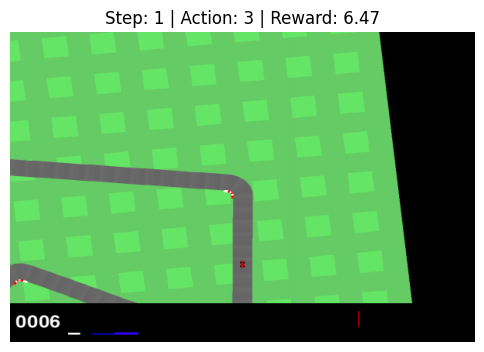

stepping


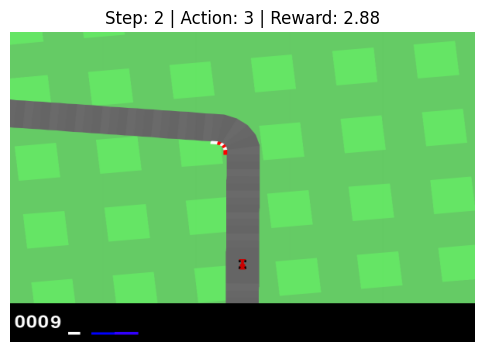

stepping


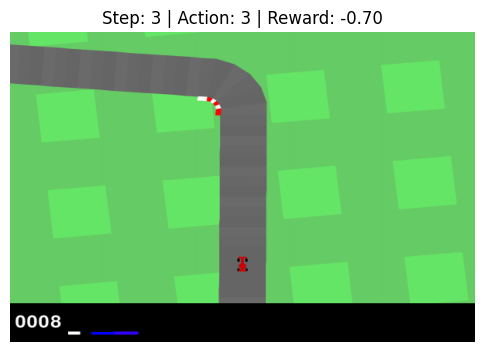

stepping


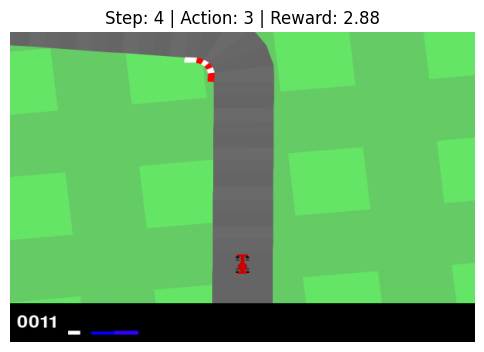

stepping


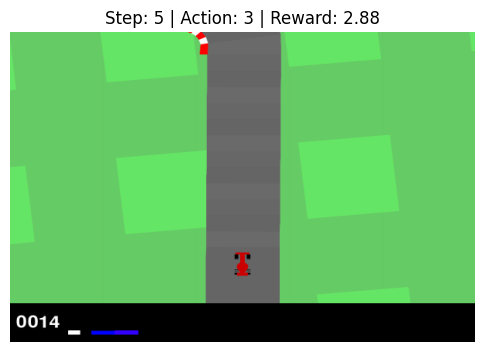

stepping


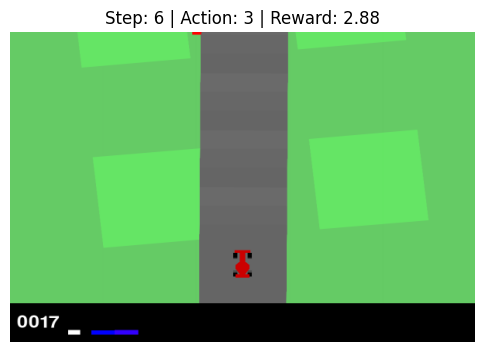

stepping


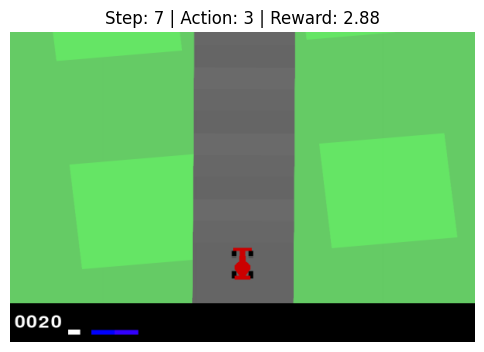

stepping


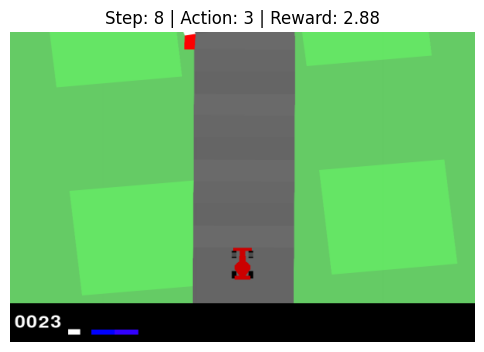

stepping


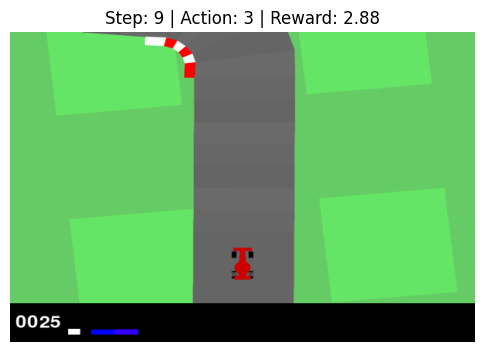

stepping


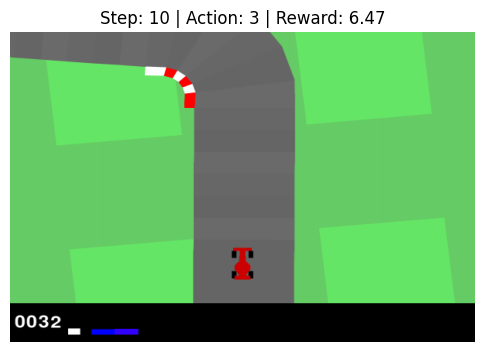

stepping


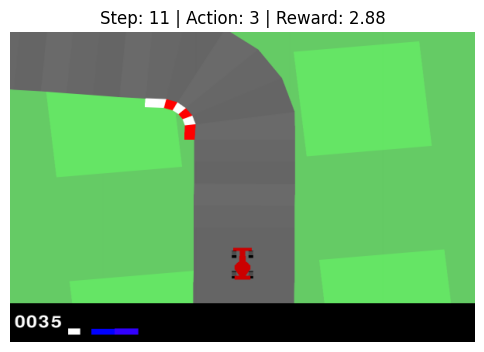

stepping


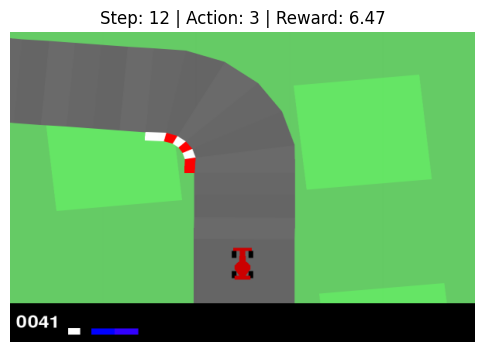

stepping


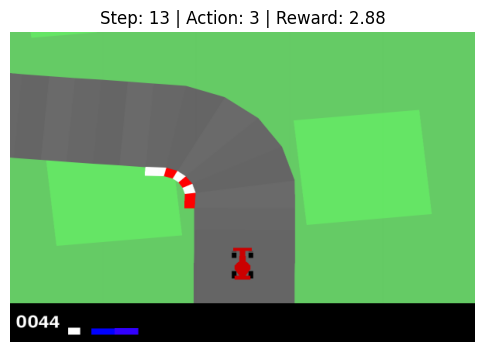

stepping


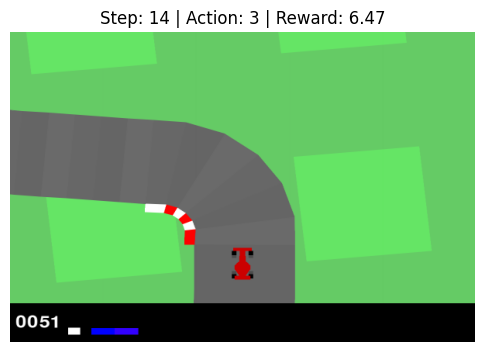

stepping


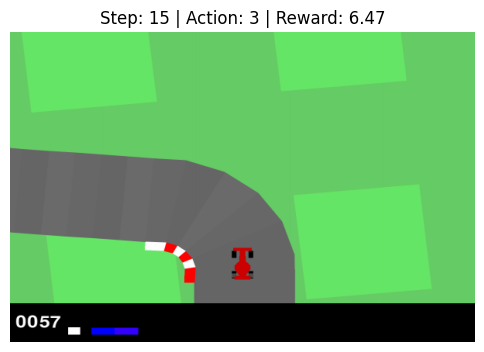

stepping


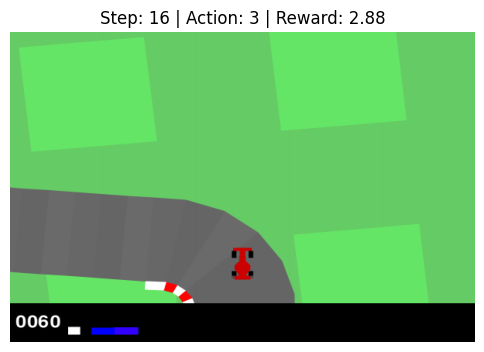

stepping


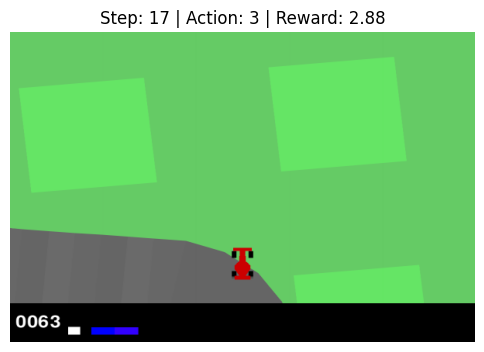

stepping


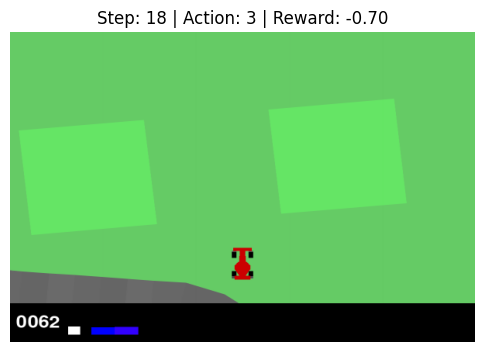

stepping


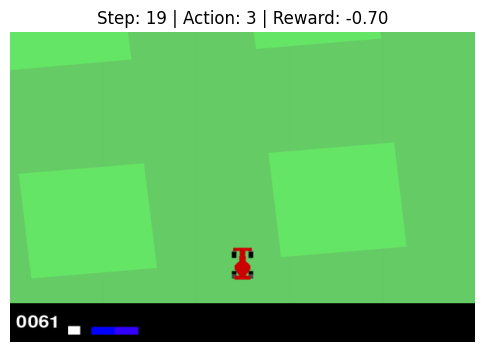

stepping


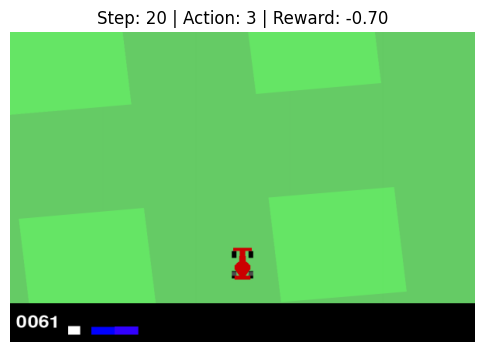

stepping


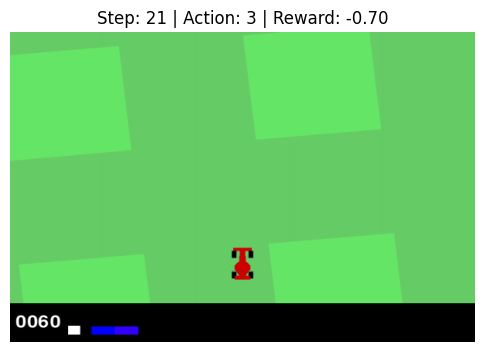

stepping


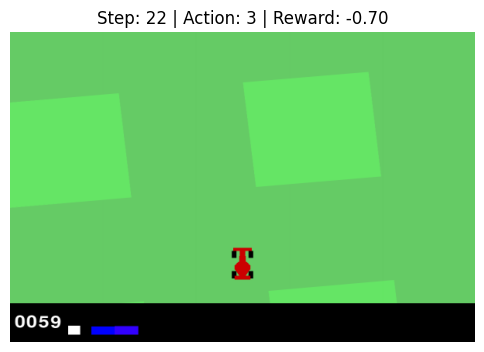

stepping


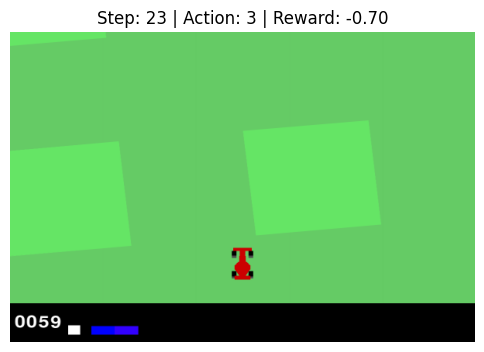

stepping


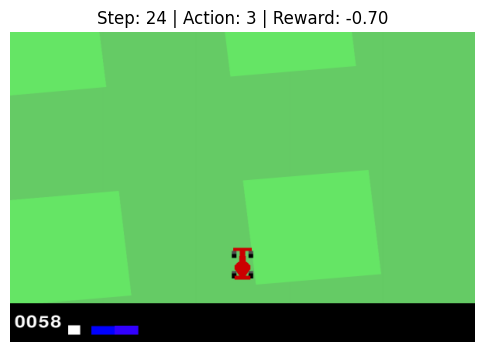

stepping


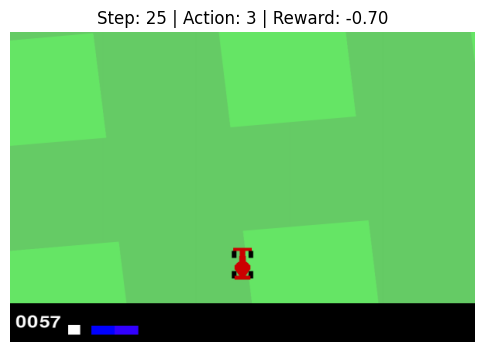

stepping


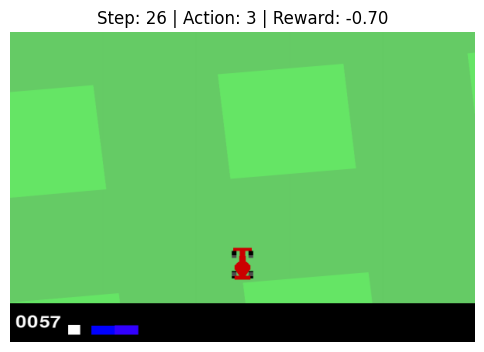

stepping


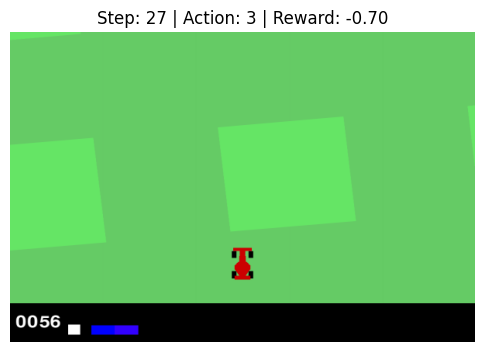

stepping


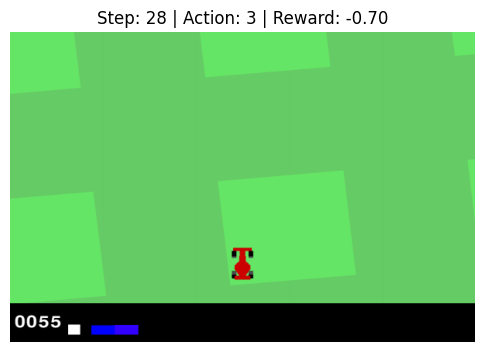

stepping


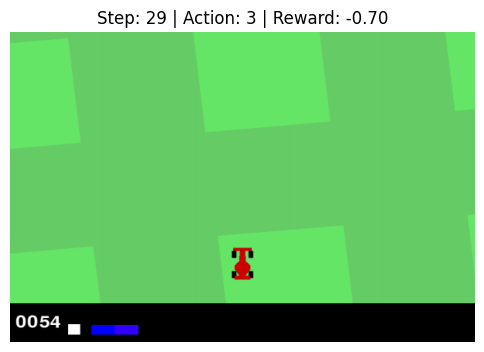

stepping


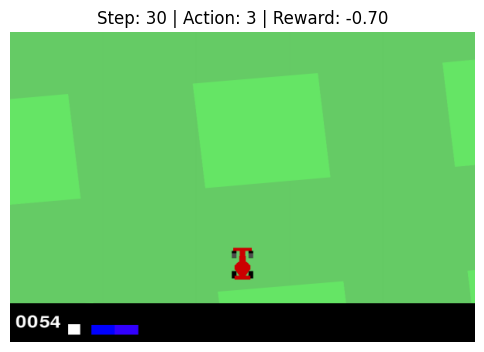

stepping


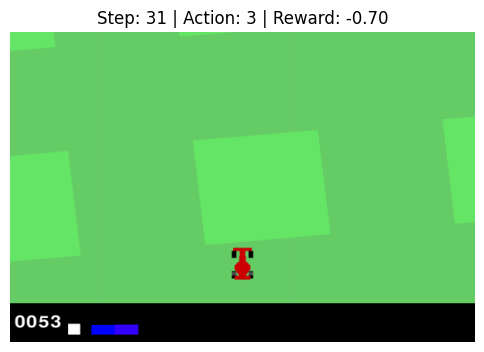

stepping


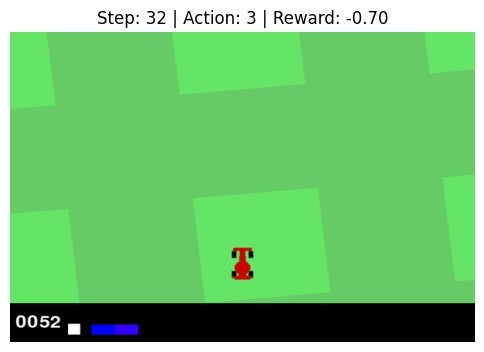

stepping


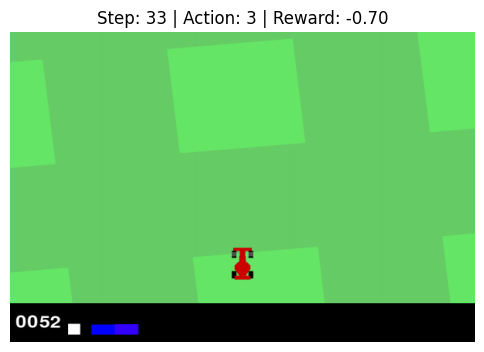

stepping


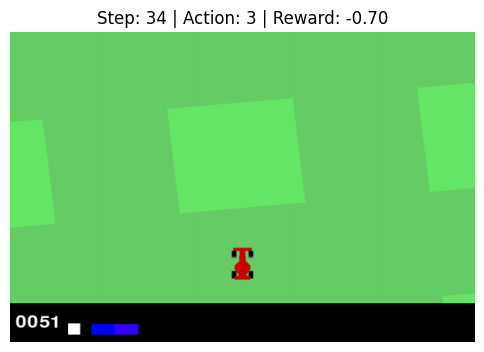

stepping


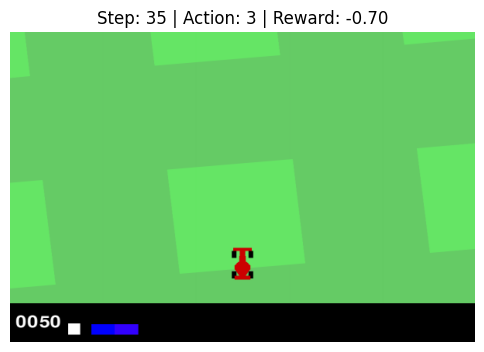

stepping


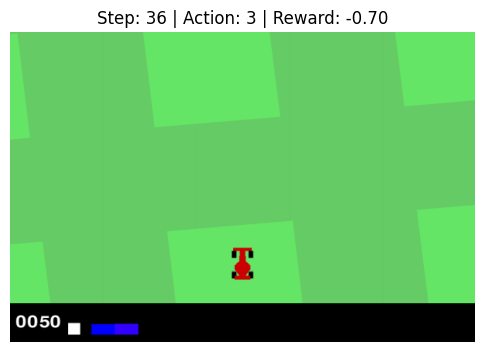

stepping


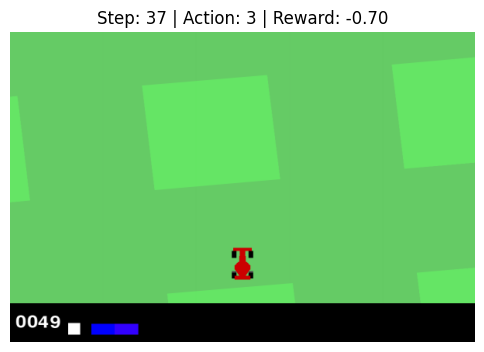

stepping


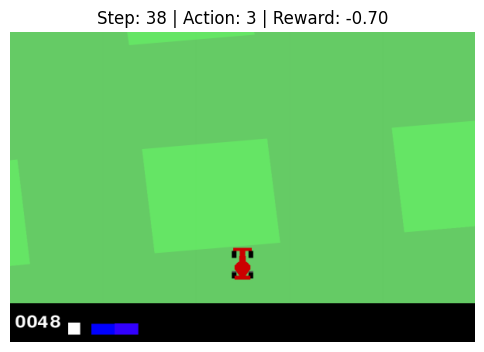

stepping


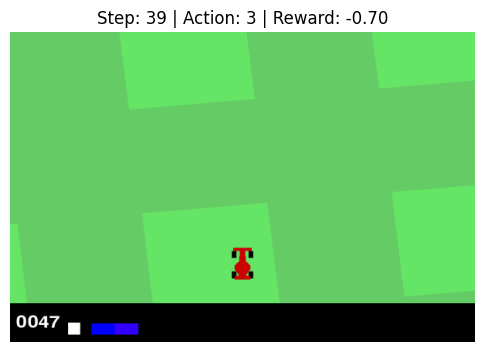

stepping


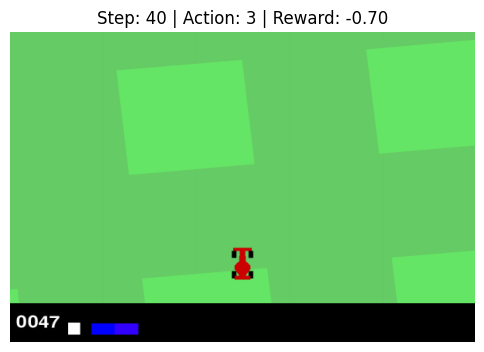

stepping


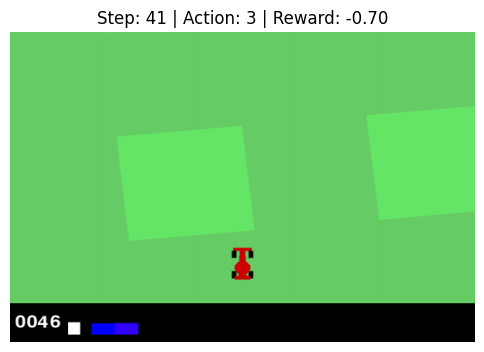

stepping


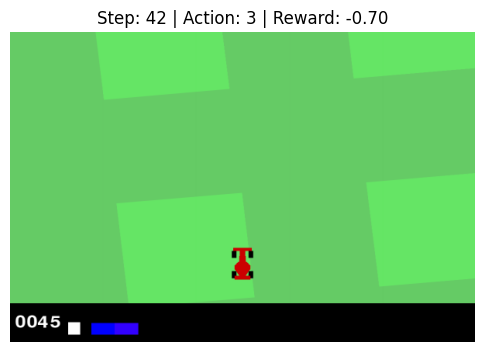

stepping


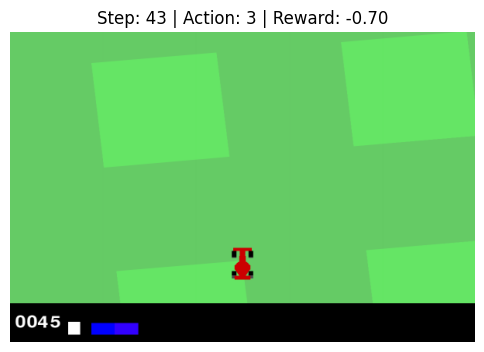

stepping


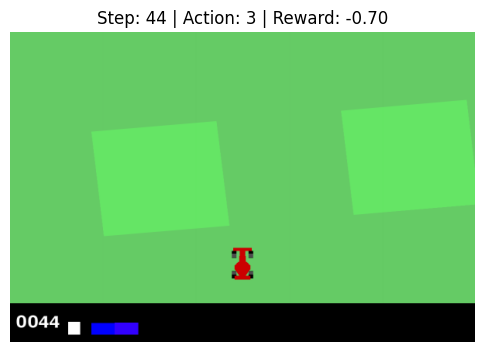

stepping


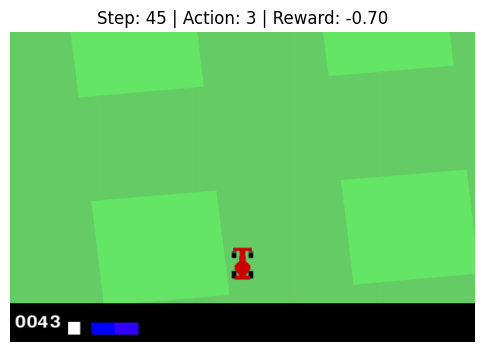

stepping


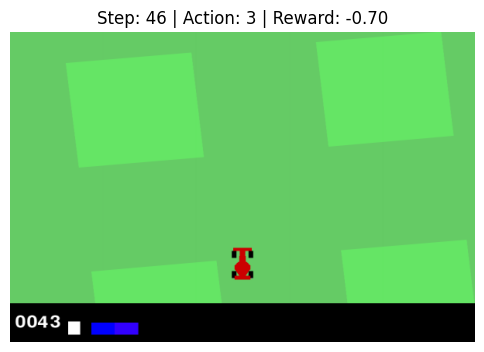

stepping


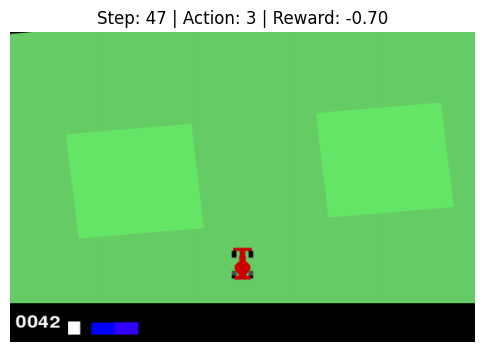

stepping


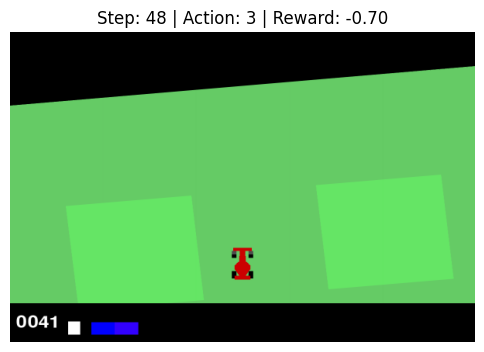

stepping


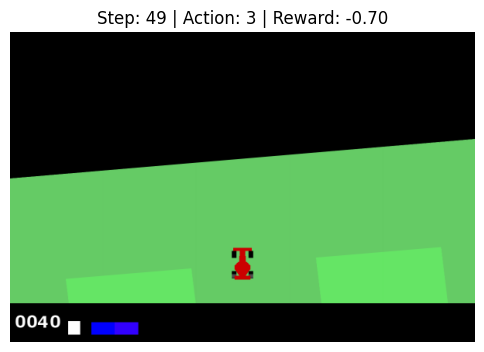

stepping


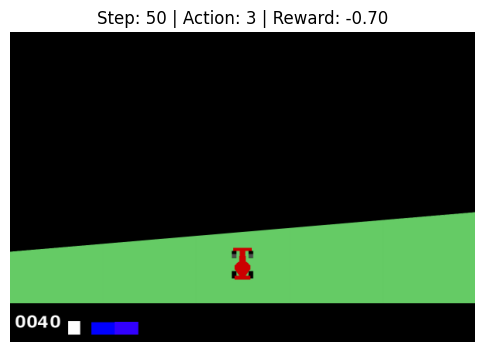

stepping


KeyboardInterrupt: 

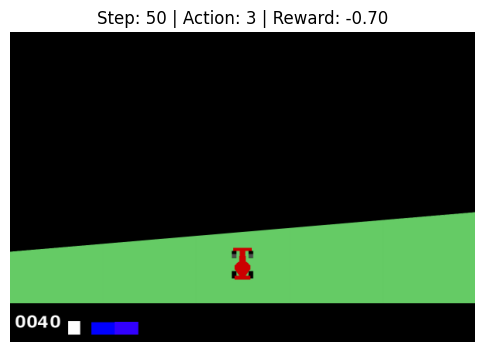

In [85]:
import matplotlib.pyplot as plt
import time
# env = LLMProcessingWrapper(
#     gym.make("CarRacing-v3", render_mode="rgb_array"), # Use "rgb_array" for rendering
#     processor=processor, 
#     prompt_formatter=car_racing_formatter,
#     max_length=512
# )
# Reset the environment to get the first observation
raw_obs, info = env.reset() # This is the processed observation dict

# Setup for visualization
fig, ax = plt.subplots(figsize=(6, 6))
# img_display = ax.imshow(env.env.render())
ax.axis('off')

# Rollout loop
terminated = False
truncated = False
total_reward = 0
episode_length = 0

while not (terminated or truncated):
    # --- A. Prepare the Observation for the Policy ---
    # The observation from the wrapper is a dict of NumPy arrays.
    # We need to manually add a batch dimension and move it to the GPU.
    obs_tensor = {
        key: torch.as_tensor(value).unsqueeze(0).to(policy.device) 
        for key, value in raw_obs.items()
    }

    # --- B. Get Action from the Policy ---
    with torch.no_grad():
        # We use deterministic=True for evaluation to see the policy's "best guess"
        # obs_tensor['pixel_values']=obs_tensor['pixel_values'].squeeze()
        actions, values, log_probs = policy.forward(obs_tensor, deterministic=False)
        # Get Action AND the full distribution from the Policy
    # # with torch.no_grad():
    # #     # Get the distribution object by calling the internal method
    # #     latent_pi, _, _ = policy._get_latent(obs_tensor)
    # #     distribution = policy._get_action_dist_from_latent(latent_pi)
        
    # #     # Get the probabilities and the sampled action
    # #     probs = distribution.get_probs().cpu().numpy()[0]
    # #     action_to_take = distribution.get_actions(deterministic=False).cpu().numpy()[0]
    # # The action is a tensor, get the NumPy value to pass to the env
    action_to_take = actions.cpu().numpy()[0]
    # action_to_take=3
    # --- C. Discretize the CarRacing Action ---
    # The formatter prompt defines our discrete action mapping. We must replicate it here.
    # [steer, gas, brake]
    # action_map = {
    #     0: [-1.0, 0.0, 0.0],  # Steer Left
    #     1: [ 1.0, 0.0, 0.0],  # Steer Right
    #     2: [ 0.0, 1.0, 0.0],  # Gas
    #     3: [ 0.0, 0.0, 0.8],  # Brake
    #     4: [ 0.0, 0.0, 0.0],  # Straight
    # }
    # continuous_action = np.array(action_map[action_to_take])
    # print(f"Action Probabilities: [L: {probs[0]:.2f}, R: {probs[1]:.2f}, Gas: {probs[2]:.2f}, Brk: {probs[3]:.2f}, Str: {probs[4]:.2f}]")
    # --- D. Step the Environment ---
    # The wrapper's step function will automatically process the next observation
    raw_obs, reward, terminated, truncated, info = env.step(action_to_take)
    
    total_reward += reward
    episode_length += 1

    # --- E. Visualize and Print Info ---
    # Update the plot with the new frame
    # img_display.set_data(env.render())
    ax.imshow(env.env.render())
    ax.set_title(f"Step: {episode_length} | Action: {action_to_take} | Reward: {reward:.2f}")
    display(fig)
    # clear_output(wait=True)
    print("stepping")
    # time.sleep(0.05) # Small delay to make it watchable

print("\n--- Rollout Finished! ---")
print(f"Total Reward: {total_reward:.2f}")
print(f"Episode Length: {episode_length}")
print(f"Termination Reason: {'Terminated' if terminated else 'Truncated'}")

# Clean up
plt.close(fig)

In [ ]:
from vlm_policies import LLMProcessingWrapper,LVLMActorCriticPolicy
wrapped_env = LLMProcessingWrapper(gym.make("CarRacing-v3"), processor=processr,max_length=512, prompt_formatter=car_racing_formatter)

[LLMProcessingWrapper] Performing dry run to build observation space...
input_ids:<class 'numpy.ndarray'>
attention_mask:<class 'numpy.ndarray'>
token_type_ids:<class 'numpy.ndarray'>
pixel_values:<class 'numpy.ndarray'>
  - Detected space 'input_ids': shape=(1, 512), dtype=int64
  - Detected space 'attention_mask': shape=(1, 512), dtype=int64
  - Detected space 'token_type_ids': shape=(1, 512), dtype=int64
  - Detected space 'pixel_values': shape=(1, 3, 896, 896), dtype=float32


In [7]:
%load_ext autoreload
%autoreload 2

In [65]:
obs = wrapped_env.reset()
print(obs)

({'input_ids': array([[     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,  

In [ ]:
# %%
# =================================================================================
# Cell 2: Test the LVLMActorCriticPolicy Forward Pass
# =================================================================================
# This cell instantiates the policy and simulates a batched forward pass,
# mimicking what the SB3 PPO trainer does internally.

import torch
import gymnasium as gym
from transformers import AutoProcessor
import numpy as np

# --- 1. Import your custom classes and formatter ---
from vlm_policies import LLMProcessingWrapper, LVLMActorCriticPolicy

# It's good practice to have formatters in a separate file
# For this example, we assume `car_racing_formatter` is defined in this scope
# from prompt_formatters import car_racing_formatter

print("--- Components Imported ---")

# --- 2. Configuration ---
MODEL_NAME = 'google/gemma-3-4b-it'
DEVICE = 'cuda:2' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4 # Let's simulate a batch of 4 parallel environments

# --- 3. Instantiate the Policy ---
# To do this, we first need a sample observation space and action space.
# We'll create a single wrapped environment just to get these.
print("\n--- Creating sample environment to get spaces for policy init... ---")
processor = AutoProcessor.from_pretrained(MODEL_NAME)
temp_env = LLMProcessingWrapper(
    gym.make("CarRacing-v3"), 
    processor=processor, 
    prompt_formatter=car_racing_formatter,
    max_length=512 # Match your expected max length
)
observation_space = temp_env.observation_space
# We need to manually discretize the action space for this test
action_space = gym.spaces.Discrete(5) 

print("\n--- Instantiating LVLMActorCriticPolicy... ---")
# Instantiate the policy. It will be moved to the correct device via device_map="auto"
# We provide a dummy learning rate schedule.
policy = LVLMActorCriticPolicy(
    observation_space=observation_space,
    action_space=action_space,
    lr_schedule=lambda _: 1e-4, # Dummy lambda
    model_name=MODEL_NAME,
    device=DEVICE,
    # use_4bit=True, # Use 4-bit to save memory in the notebook
    use_lora=True
)

policy.eval() # Set to evaluation mode for inference
print("--- Policy Instantiated Successfully ---")

# --- 4. Manually Create a Batch of Observations ---
# This simulates what `VecEnv` does automatically.
print(f"\n--- Generating a sample batch of {BATCH_SIZE} observations... ---")
batch_obs_list = []
for _ in range(BATCH_SIZE):
    raw_obs, _ = temp_env.reset()
    # The wrapper directly gives us the processed observation dictionary
    batch_obs_list.append(raw_obs)
    
# --- 5. Manually Collate the Batch ---
# This is the key step: stack the individual dictionaries into one.
collated_batch = {}
# Get the keys from the observation space
for key in observation_space.keys():
    # Stack the numpy arrays from each dict in the list along a new batch dimension
    collated_batch[key] = np.stack([obs[key] for obs in batch_obs_list])

print("--- Batch Collated ---")
for key, value in collated_batch.items():
    print(f"  - Collated '{key}' shape: {value.shape}") # Should be (BATCH_SIZE, 1, ...)

# --- 6. Convert to Tensors and Send to Device ---
# This is what the PPO agent does before calling the policy.
batch_tensor = {
    key: torch.as_tensor(value).to(DEVICE) for key, value in collated_batch.items()
}
print("\n--- Batch converted to Tensors on device:", DEVICE, "---")

# --- 7. Run the Forward Pass! ---
print("\n--- Executing policy.forward()... ---")
with torch.no_grad():
    # The `forward` method is the core of the policy's inference logic.
    actions, values, log_probs = policy.forward(batch_tensor, deterministic=False)

# --- 8. Inspect the Outputs ---
print("\n--- Forward Pass Completed! Inspecting outputs... ---")
print(f"Actions shape: {actions.shape}")
print(f"Actions tensor: {actions.cpu().numpy()}")
print("-" * 20)
print(f"Values shape: {values.shape}")
print(f"Values tensor: {values.cpu().numpy().flatten()}")
print("-" * 20)
print(f"Log probabilities shape: {log_probs.shape}")
print(f"Log probabilities tensor: {log_probs.cpu().numpy()}")

# Clean up the environment
temp_env.close()

--- Components Imported ---

--- Creating sample environment to get spaces for policy init... ---
[LLMProcessingWrapper] Performing dry run to build observation space...
  - Detected space 'input_ids': shape=(1, 512), dtype=int64
  - Detected space 'attention_mask': shape=(1, 512), dtype=int64
  - Detected space 'token_type_ids': shape=(1, 512), dtype=int64
  - Detected space 'pixel_values': shape=(1, 3, 896, 896), dtype=float32

--- Instantiating LVLMActorCriticPolicy... ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LoRA enabled. Trainable parameters:
trainable params: 16,394,240 || all params: 4,316,473,712 || trainable%: 0.3798
--- Policy Instantiated Successfully ---

--- Generating a sample batch of 4 observations... ---
--- Batch Collated ---
  - Collated 'attention_mask' shape: (4, 1, 512)
  - Collated 'input_ids' shape: (4, 1, 512)
  - Collated 'pixel_values' shape: (4, 1, 3, 896, 896)
  - Collated 'token_type_ids' shape: (4, 1, 512)

--- Batch converted to Tensors on device: cuda:2 ---

--- Executing policy.forward()... ---

--- Forward Pass Completed! Inspecting outputs... ---
Actions shape: torch.Size([4, 5])
Actions tensor: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
--------------------
Values shape: torch.Size([4, 1])


TypeError: Got unsupported ScalarType BFloat16

In [ ]:
policy.action_token_ids = [ids[0] for ids in policy.action_token_ids_tensor]

[[236771], [236770], [236778], [236800], [236812]]

In [ ]:
# %%
# =================================================================================
# Cell 6: Advanced Environment with Frame Stacking via Prompt Formatting
# =================================================================================
# This cell defines a new, stateful prompt formatter that handles frame stacking
# internally, creating a history of captioned images for the LVLM.

import gymnasium as gym
from PIL import Image
import numpy as np
from typing import Any, Tuple, List, Dict
from collections import deque

# --- Ensure previous components exist ---
assert 'LLMProcessingWrapper' in locals(), "Please run the cell defining LLMProcessingWrapper."
assert 'processor' in locals(), "Please run a cell that defines the `processor`."

print("--- Defining Advanced Frame Stacking Formatter ---")

class FrameStackingPromptFormatter:
    """
    A stateful class that formats prompts for an environment by stacking
    and captioning the last N frames.

    This provides crucial temporal context to the LVLM in a natural,
    conversational format.
    """
    def __init__(self, num_stack: int = 4):
        self.num_stack = num_stack
        # Use a deque to automatically manage the history of frames
        self.frames = deque(maxlen=num_stack)
        self.is_reset = True

    def __call__(self, obs: np.ndarray) -> Tuple[List[Dict], List[Image.Image]]:
        """
        The main formatting method called by the LLMProcessingWrapper.

        :param obs: The current raw NumPy image observation from the environment.
        :return: A tuple containing the chat structure and a list of PIL images.
        """
        # --- 1. Update Frame History ---
        # On the very first step of an episode, fill the buffer with the first frame.
        if self.is_reset:
            for _ in range(self.num_stack):
                self.frames.append(obs)
            self.is_reset = False
        else:
            # For subsequent steps, just add the new frame.
            self.frames.append(obs)
        
        # The list of images to pass to the processor is our deque of frames.
        images = [Image.fromarray(frame) for frame in self.frames]

        # --- 2. Build the Chat Content List ---
        # This is where we use the interleaving trick.
        content_list = []
        # Add the oldest frames first
        for i in range(self.num_stack - 1):
            content_list.append({"type": "text", "text": f"This was the view {self.num_stack - 1 - i} steps ago:"})
            content_list.append({"type": "image"}) # Placeholder for image i
        
        # Add the most recent frame
        content_list.append({"type": "text", "text": "This is the current view:"})
        content_list.append({"type": "image"}) # Placeholder for the last image

        # --- 3. Add the Final Prompt ---
        action_prompt = (
            "\nYou are an expert driver. Based on the sequence of images showing your recent history, "
            "choose one of the following actions to stay on the track:\n"
            "0: Steer hard left\n"
            "1: Steer hard right\n"
            "2: Accelerate hard\n"
            "3: Brake hard\n"
            "4: Go straight (no action)"
        )
        content_list.append({"type": "text", "text": action_prompt})

        # --- 4. Assemble the Final Chat Dictionary ---
        chat = [{"role": "user", "content": content_list}]
        
        return chat, images
    
    def reset(self):
        """Resets the internal state of the formatter."""
        self.frames.clear()
        self.is_reset = True

# --- 3. Instantiate the New Stateful Formatter ---
# It's now an object, not just a function.
frame_stacking_formatter = FrameStackingPromptFormatter(num_stack=2)

# --- 4. Create a Discretized Action Wrapper for CarRacing ---
# To make the final env compatible with our discrete policy, we need a wrapper
# to handle the action conversion.
class DiscretizedCarRacing(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Define the discrete action space
        self.action_space = gym.spaces.Discrete(5)
        
        # Map discrete actions to the environment's continuous action space
        self.action_map = {
            0: [-1.0, 0.0, 0.0],  # Steer Left
            1: [ 1.0, 0.0, 0.0],  # Steer Right
            2: [ 0.0, 1.0, 0.0],  # Gas
            3: [ 0.0, 0.0, 0.8],  # Brake
            4: [ 0.0, 0.0, 0.0],  # Straight
        }

    def action(self, action):
        return np.array(self.action_map[action])

    # We also need to hook into reset to reset our formatter's state
    def reset(self, **kwargs):
        # Access the formatter from the outer wrapper
        # This is a bit of a hack for the REPL, a cleaner way would be to pass the formatter in
        frame_stacking_formatter.reset()
        return super().reset(**kwargs)

# --- 5. Create the Final, Fully-Equipped Environment ---
print("\n--- Creating the final, wrapped environment with frame stacking... ---")

# a. Create the base environment
base_env = gym.make("CarRacing-v3",render_mode="rgb_array")

# b. Apply the action discretizer
discretized_env = DiscretizedCarRacing(base_env)

# c. Apply the LLM Processing wrapper with our new stateful formatter
env = LLMProcessingWrapper(
    discretized_env,
    processor=processor, 
    prompt_formatter=frame_stacking_formatter, # Use the new formatter object
    max_length=1024, # Increase max_length for the larger prompt
)

print("\n--- Environment `env` is now ready for your manual rollout cell! ---")
print("It provides a history of 4 images in the prompt at each step.")

# --- Quick Test ---
print("\n--- Testing one step of the new environment... ---")
obs, _ = env.reset()
print(obs['input_ids'])
print("Observation received. Keys:", obs.keys())
print("Shape of 'input_ids':", obs['input_ids'].shape) # Should have a larger sequence length
# env.close()

--- Defining Advanced Frame Stacking Formatter ---

--- Creating the final, wrapped environment with frame stacking... ---
[LLMProcessingWrapper] Performing dry run to build observation space...
  - Detected space 'input_ids': shape=(1, 1024), dtype=int64
  - Detected space 'attention_mask': shape=(1, 1024), dtype=int64
  - Detected space 'token_type_ids': shape=(1, 1024), dtype=int64
  - Detected space 'pixel_values': shape=(2, 3, 896, 896), dtype=float32

--- Environment `env` is now ready for your manual rollout cell! ---
It provides a history of 4 images in the prompt at each step.

--- Testing one step of the new environment... ---
[[   0    0    0 ...  105 4368  107]]
Observation received. Keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'pixel_values'])
Shape of 'input_ids': (1, 1024)


In [93]:
with torch.no_grad():
    # The `forward` method is the core of the policy's inference logic.
    actions, values, log_probs = policy.forward(batch_tensor, deterministic=False)

In [90]:
result

(tensor([4], device='cuda:2'),
 tensor([[6.1562]], device='cuda:2', dtype=torch.bfloat16,
        grad_fn=<AddmmBackward0>),
 tensor([0.], device='cuda:2', dtype=torch.bfloat16, grad_fn=<SqueezeBackward1>))

ValueError: too many values to unpack (expected 4)

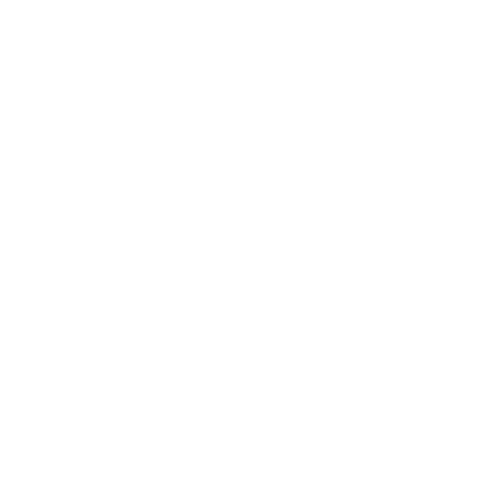

In [85]:
import matplotlib.pyplot as plt
import time
# env = LLMProcessingWrapper(
#     gym.make("CarRacing-v3", render_mode="rgb_array"), # Use "rgb_array" for rendering
#     processor=processor, 
#     prompt_formatter=car_racing_formatter,
#     max_length=512
# )
# Reset the environment to get the first observation
raw_obs, info = env.reset() # This is the processed observation dict

# Setup for visualization
fig, ax = plt.subplots(figsize=(6, 6))
# img_display = ax.imshow(env.env.render())
ax.axis('off')

# Rollout loop
terminated = False
truncated = False
total_reward = 0
episode_length = 0

while not (terminated or truncated):
    # --- A. Prepare the Observation for the Policy ---
    # The observation from the wrapper is a dict of NumPy arrays.
    # We need to manually add a batch dimension and move it to the GPU.
    obs_tensor = {
        key: torch.as_tensor(value).unsqueeze(0).to(policy.device) 
        for key, value in raw_obs.items()
    }

    # --- B. Get Action from the Policy ---
    with torch.no_grad():
        # We use deterministic=True for evaluation to see the policy's "best guess"
        actions, values, log_probs = policy.forward(obs_tensor, deterministic=False)
        # Get Action AND the full distribution from the Policy
    # with torch.no_grad():
    #     # Get the distribution object by calling the internal method
    #     latent_pi, _, _ = policy._get_latent(obs_tensor)
    #     distribution = policy._get_action_dist_from_latent(latent_pi)
        
    #     # Get the probabilities and the sampled action
    #     probs = distribution.get_probs().cpu().numpy()[0]
    #     action_to_take = distribution.get_actions(deterministic=False).cpu().numpy()[0]
    # The action is a tensor, get the NumPy value to pass to the env
    action_to_take = actions.cpu().numpy()[0]

    # --- C. Discretize the CarRacing Action ---
    # The formatter prompt defines our discrete action mapping. We must replicate it here.
    # [steer, gas, brake]
    action_map = {
        0: [-1.0, 0.0, 0.0],  # Steer Left
        1: [ 1.0, 0.0, 0.0],  # Steer Right
        2: [ 0.0, 1.0, 0.0],  # Gas
        3: [ 0.0, 0.0, 0.8],  # Brake
        4: [ 0.0, 0.0, 0.0],  # Straight
    }
    continuous_action = np.array(action_map[action_to_take])
    print(f"Action Probabilities: [L: {probs[0]:.2f}, R: {probs[1]:.2f}, Gas: {probs[2]:.2f}, Brk: {probs[3]:.2f}, Str: {probs[4]:.2f}]")
    # --- D. Step the Environment ---
    # The wrapper's step function will automatically process the next observation
    raw_obs, reward, terminated, truncated, info = env.step(continuous_action)
    
    total_reward += reward
    episode_length += 1

    # --- E. Visualize and Print Info ---
    # Update the plot with the new frame
    img_display.set_data(env.render())
    # ax.set_title(f"Step: {episode_length} | Action: {action_to_take} | Reward: {reward:.2f}")
    # display(fig)
    # clear_output(wait=True)
    print("stepping")
    time.sleep(0.05) # Small delay to make it watchable

print("\n--- Rollout Finished! ---")
print(f"Total Reward: {total_reward:.2f}")
print(f"Episode Length: {episode_length}")
print(f"Termination Reason: {'Terminated' if terminated else 'Truncated'}")

# Clean up
plt.close(fig)